In [1]:
#Packages:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from camera_matrix import camera_matrix
import time
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
# Read a sequence of 2 stereoscopic images, synchronized (frame 107 to 131 for video 1, frame 45 to 69 for video 2)
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/vid1_dx.MP4")
cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010031.MP4")
cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/vid1_sx.MP4")

camera_droite = "img_d"
camera_gauche = "img_g"

def save_BW_img(cap):
    image= []
    while True:
  # Lire l'image suivante de la vidéo
        ret, frame = cap.read()

  # Vérifier si la fin de la vidéo a été atteinte
        if not ret:
            break

  # Convertir l'image en noir et blanc
        img_gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        image.append(img_gray)
    cv2.destroyAllWindows()
    cap.release() 
    return image

        
dx_images = save_BW_img(cap0)
sx_images = save_BW_img(cap1)


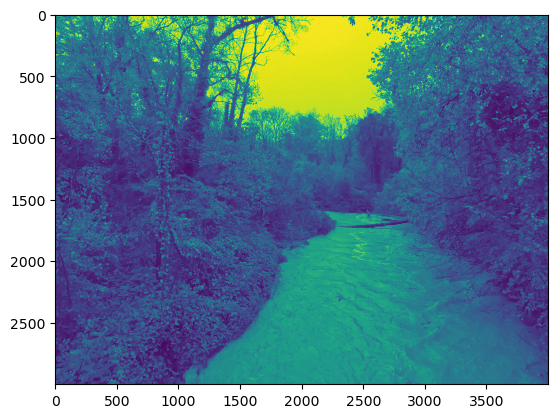

In [3]:
# Show two synchronized images
from PIL import Image
import matplotlib.pyplot as plt

# Assuming you already have bw_images from the previous code

# Access the first two images
image1 = sx_images[0]
image2 = dx_images[0]

plt.imshow(image2)
plt.show()

In [4]:
# Define the y-axis range
start_y = 2000
end_y = 2750

# define the x-axis range
start_x = 1900
end_x = 3000
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

# Create an empty list to store the selected stripes
sx_stripes = []

# Loop through the images and select the stripe for each image
for img in sx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    sx_stripes.append(selected_stripe)

    dx_stripes = []

# Loop through the images and select the stripe for each image
for img in dx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    dx_stripes.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image

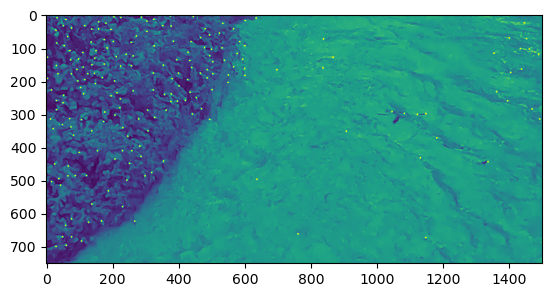

(<matplotlib.image.AxesImage at 0x14b75c8d0>, None)

In [5]:
nb_points = 200
def keypoint(nb_points, image):
    corners = cv2.goodFeaturesToTrack(image, nb_points,0.01,20)
    corners = np.intp(corners)
    return corners # les paires de coordonnées de chaque keypoints

corners = keypoint(nb_points, dx_stripes[0])
 
img_circles = dx_stripes[0].copy()

for i in corners:
 x,y = i.ravel()
 cv2.circle(img_circles,(x,y),3,255,-1)
 
plt.imshow(img_circles),plt.show()

In [6]:
def NCC_window(x,y, image): # normalized cross correlation window of 9x9 around our pixel of 
    # Do not forget that if x0-4 or x0+5 is out of the image, we will not take into account this tracking point. 
    NCC = image[y-4:y+5, x-4:x+5] # rows and columns are switched in the image ( image size is 750x1500)
    return NCC

In [7]:
def tracking(x0,y0,image, NCC):
    match = 1
    x1 = 0
    y1 = 0
    for x in range(x0-7, x0+7): 
        for y in range(y0-7, y0+7):
            img_comp = NCC_window(x,y,image)
            res = cv2.matchTemplate(img_comp,NCC, 1)
            if res < match: 
                match = res
                x1 = x
                y1 = y
    return(x1, y1)

/var/folders/hg/s7by_zc16hd9fxwtj6cx5wrr0000gn/T/ipykernel_49306/3804857945.py:33: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arctan((x1-x0)/(y1-y0))
/var/folders/hg/s7by_zc16hd9fxwtj6cx5wrr0000gn/T/ipykernel_49306/3804857945.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  angle = np.arctan((x1-x0)/(y1-y0))


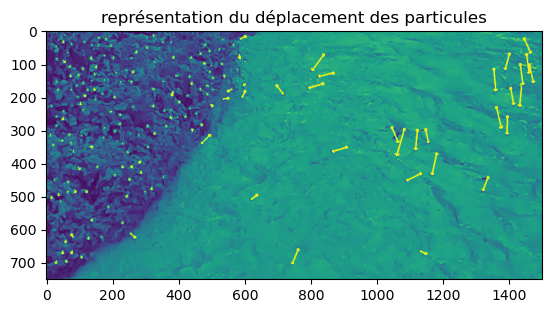

KeyboardInterrupt: 

In [8]:
stats = pd.DataFrame()

for img_nb in range(0, len(dx_stripes)):
    if img_nb % 30 == 0: 
        corners = keypoint(nb_points, dx_stripes[img_nb])
        coord_track = corners[:,0,:2].ravel().reshape(nb_points,2)
        displacement = np.zeros((nb_points,15,2))
        point_i = 0
        point_delete = []
        for x,y in coord_track: # bug sur le deuxieme point parce que (479,9) trop proche du bord de l'image... donc peut pas check les 15 pixels autour...
            for i in range(img_nb + 1, img_nb + 16):
                if x< 11 or x > 1489 or y < 11 or y > 714: 
                    #stock les points à enlever
                    point_delete= np.append(point_delete, point_i)
                    break #skip au prochain point
                NCC = NCC_window(x,y, dx_stripes[i-1])
                displacement[point_i, i-1-img_nb ,:]= x,y
                x,y = tracking(x,y, dx_stripes[i], NCC)
            point_i += 1
        point_delete= point_delete.astype(int)
        displacement = np.delete(displacement,point_delete,0 )
        img_circles = dx_stripes[img_nb].copy()

        direction = []
        length = []
        for j in range(displacement.shape[0]):
            x0,y0 = displacement[j,0,:]
            x1,y1 = displacement[j,14,:]
            # recupere angle et taille des vecteurs

            #if y1-y0 == 0: trouver le moyen d'élimier les vecteurs ou on divise par 0 (marche pas pour le moment parce que pas la meme taille que les autres trucs du dataframe)
            #    break
            angle = np.arctan((x1-x0)/(y1-y0))
            intensity = np.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))
            direction = np.append(direction, angle)
            length= np.append(length, intensity)

            # représente les vecteurs sur les images
            cv2.circle(img_circles,(int(x0),int(y0)),5,255,-1)
            cv2.circle(img_circles,(int(x1),int(y1)),5,(70,255,212),-1)
            cv2.arrowedLine(img_circles, (int(x0),int(y0)), (int(x1),int(y1)), 255, 4)

        x0 = displacement[:, 0, 0]
        y0 = displacement[:, 0, 1]
        x1 = displacement[:, 14, 0]
        y1 = displacement[:, 14, 1]

        stats_temp = pd.DataFrame({
            'x0': x0,
            'y0': y0,
            'x1': x1,
            'y1': y1,
            'direction': direction,
            'length': length
        })
        stats = pd.concat([stats, stats_temp], ignore_index=True)
        plt.title('représentation du déplacement des particules')
        plt.imshow(img_circles),plt.show()

print(stats.tail())

In [ ]:
display(stats[['direction', 'length']].describe())

,direction,length
count,1132.000000,1132.000000
mean,-0.074742,47.950567
std,0.560030,16.895665
min,-1.570796,1.000000
25%,-0.447168,37.013511
50%,-0.085448,49.168020
75%,0.311135,59.253685
max,1.570796,104.235311
